In [0]:
import os
import pickle
import scipy
import numpy as np 
from torchvision.utils import save_image    
import torchvision.utils as vutils
import torchvision.datasets as dset
from torchsummary import summary
import torch
from torch.utils import data
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as FVis
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torchsummary import summary
from torch.autograd import grad, Variable

import math
import random

from tqdm import tqdm_notebook as tqdm


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import copy
from IPython.display import HTML

## Parameters

In [0]:
val_split = 0.1  #@param {type: "number"}
batch_size = 64  #@param {type: "integer"}
workers = 2
n_epochs = 60     #@param {type: "integer"}
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
noise_latent_dim = 100
n_feature_maps_g = 64  #@param {type: "integer"}
# used for the discriminator and VAE encoder
n_feature_maps_d = 64 #@param {type: "integer"}
beta1 = 0 # as mentioned in the improved wGan paper which would reduce the dependency on previous gradient for the first moment in Adam
p_coeff = 10 # lambda used as a coefficient for gradient penalty
# https://www.quora.com/Why-do-people-update-the-discriminator-in-GANs-just-once-and-not-until-convergence-before-updating-the-generator-in-practice
n_critic = 1 #@param {type: "integer"} # number of updates to discriminator before updating the generator to get a higer quality gradient signal from a converged discriminator
lr_g = 0.0001
lr_d = 0.0003
#lr*4 for the discriminator
model_prefix = 'exp_base_80'
decay_lr = True  #@param {type: "boolean"}
# to use double the normal batch size 
# for the generator back prop
generator_batch_size_factor = 1 #@param {type: "integer"}

In [0]:
#google drive params
take_backup = False #@param {type: "boolean"}
# take backup every n epochs
backup_every = 4 #@param {type: "integer"}
# Set random seem for reproducibility
manualSeed = 123 #@param {type: "integer"}
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)
os.environ['PYTHONHASHSEED'] = str(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed)

Random Seed:  123


## Utilities

In [0]:
# lr optimizer updater
def update_optimizer_lr(optimizer,lr,decay):
  for param_group in optimizer.param_groups:
      param_group['lr'] = lr* decay   

def visualize_loss(loss_1, loss_2, first_legend, second_legend, y_label):
    plt.figure(figsize=(10,5))
    plt.title("{} and {} Loss During Training".format(first_legend, second_legend))
    plt.plot(loss_1,label=first_legend)
    plt.plot(loss_2,label=second_legend)
    plt.xlabel("iterations")
    plt.ylabel(y_label)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()


In [0]:
def sample_image(generator, size):
    with torch.no_grad():
      if size%batch_size!=0:
          z = sample_noise(math.ceil(size*1.0/batch_size) * batch_size)
      else:
          z = sample_noise(size)
      return generator(z)[:size]

def sample_noise(size):
    z = torch.FloatTensor(size,noise_latent_dim).to(device)
    z.data.normal_() # generating latent space based on normal distribution
    return z

In [0]:
def gradients_status(model,flag):
    for p in model.parameters():
        p.requires_grad = flag

### Plotting real and fake images

In [0]:

def show_real_fake_images(real_batch,img_list):
    # Grab a batch of real images from the dataloader

    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=4, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[:64],(1,2,0)))
    plt.show()

### Data and latent space interpolation

In [0]:
def latent_space_interpolation(generator_model, noise_space_1,noise_space_2, nb_frames):
    """Used to check the latent space of the trained model"""
    with torch.no_grad():
        z = [alpha * noise_space_1 + (1 - alpha) * noise_space_2 for alpha in np.linspace(0.1, 1, nb_frames)]
        z = torch.cat(z)
        imgs = generator_model(z.to(device)).detach().cpu()
        plt.figure(figsize=(15,15))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(vutils.make_grid(imgs[:nb_frames],nrow=nb_frames, padding=2, normalize=True).permute(1, 2, 0))
        plt.show()
        
def data_space_interpolation(generator_model, nb_frames):
    """Used to check the latent space of the trained model"""
    try:
        generator_model.eval()
    except:
        pass
    with torch.no_grad():
        img_1 = sample_image(generator_model,1)
        img_2 = sample_image(generator_model,1)
        out_imgs = []
        for alpha in np.linspace(0,1,nb_frames):
          new_img = alpha * img_1 + (1-alpha) * img_2
          out_imgs.append(new_img)
        imgs = torch.cat(out_imgs).detach().cpu()
        plt.figure(figsize=(15,15))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(vutils.make_grid(imgs,nrow=nb_frames, padding=2, normalize=True).permute(1, 2, 0))
        plt.show()

def disentangled_representation_view(generator_model, noise_space_1, nb_dims,perturbed_dims = [],added_epsilon=2):
    """Used to check the latent space of the trained model"""
    with torch.no_grad():
        extra_z = [sample_noise(1) for i in range(batch_size-1)] # better to predict a batch for batchnorm
        z = torch.cat([noise_space_1]+extra_z)
        original_image = torch.squeeze(generator_model(z)[0]).detach().cpu()
        noise_space_1 = noise_space_1.detach().cpu().numpy()
        for i in range(nb_dims ):
            if len(perturbed_dims)>i:
                perturbation_index = perturbed_dims[i] 
            else:
                perturbation_index = random.randrange(noise_latent_dim) 
            epsilon = np.zeros(noise_space_1.shape)
            
            
            epsilon[:,perturbation_index] = added_epsilon 
            z = torch.from_numpy(noise_space_1 + epsilon).float().to(device)
            z = torch.cat([z]+extra_z)
            generated_img = torch.squeeze(generator_model(z)[0]).detach().cpu()
            
            plt.axis("off")
            plt.title("Perturbing Dim {}".format(perturbation_index))
            plt.imshow(vutils.make_grid(torch.stack((original_image,generated_img),dim=0),nrow=2, padding=2, normalize=True).permute(1, 2, 0))
            plt.show() 

## Google Drive Backup Utils

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
from tensorflow.keras.models import load_model

if take_backup:
  auth.authenticate_user()
def download_file_drive(file_name,out_file_name):
  drive_service = build('drive', 'v3')
  results = drive_service.files().list(
          q="name = '"+file_name+"'", fields="files(id)").execute()
  kaggle_api_key = results.get('files', [])
  try:
    os.makedirs(os.path.dirname(out_file_name), exist_ok=True)
  except:
    pass
  try:
    request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
    fh = io.FileIO(out_file_name, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print("Download %d%%." % int(status.progress() * 100))
    os.chmod(out_file_name, 600)
    return True
  except:
    return False

In [0]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# from google.colab import auth
from oauth2client.client import GoogleCredentials
#@title Functions
def upload_to_drive(filename):
  if os.path.isfile(filename):
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    to_upload = drive.CreateFile({'title': filename})
    to_upload.SetContentFile(filename)
    to_upload.Upload()
    return to_upload
  else:
    print('filename not found -_-')
    return None

## Data Loading

In [0]:
!wget -nc http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget -nc http://ufldl.stanford.edu/housenumbers/test_32x32.mat

File ‘train_32x32.mat’ already there; not retrieving.

File ‘test_32x32.mat’ already there; not retrieving.



In [0]:

class MatDataReader():
    def __init__(self,file_path):
        data = scipy.io.loadmat(file_path)
        self.images = torch.from_numpy(data['X'] ).permute(3,2,0,1)
        self.labels = torch.from_numpy(data['y']).int()
    
    def __len__(self):
        return self.labels.size()[0]
    
    def get_all_indexes(self):
        return np.arange(len(self))

    def __getitem__(self, index):
        x = self.images[index]
        y = self.labels[index][0]
        return x, y


class Dataset(data.Dataset):
    def __init__(self, data_reader , sampled_indexes, transforms=None):
        self.reader = data_reader
        self.transforms = transforms
        self.sampled_indexes = sampled_indexes

    def __len__(self):
        if not(self.sampled_indexes is None):
            return self.sampled_indexes.shape[0]
        return len(self.reader)

    def __getitem__(self, index):
        if not(self.sampled_indexes is None ):
            index = self.sampled_indexes[index]
        x,y = self.reader[index]
        x = FVis.to_pil_image(x)
        
        if self.transforms:
            x = self.transforms(x)
        return x, y


In [0]:
def load_data(transformations):
  train_reader = MatDataReader('train_32x32.mat')
  
  # splitting data into train and validation set
  train_indexes, val_indexes =  train_test_split(train_reader.get_all_indexes(),test_size=val_split, shuffle=True)  


  train_dataset = Dataset(train_reader, train_indexes, transformations)
  val_dataset = Dataset(train_reader, val_indexes, transformations)

  test_reader = MatDataReader('test_32x32.mat')
  test_dataset = Dataset(test_reader,None, transformations)


  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=workers,drop_last=True,pin_memory=True)

  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=workers,drop_last=True,pin_memory=True)

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                           shuffle=True, num_workers=workers,drop_last=True,pin_memory=True)

  return train_loader, val_loader, test_loader

In [0]:
  transformations = transforms.Compose([
                                 transforms.Resize(32),
                                 transforms.CenterCrop(32),
                                 transforms.ToTensor(), # move from pil range [0,255] to [0,1] range and to tensor format
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # used to move the range from [0,1] to [-1,1] which will match the tanh in the output which gives a good color variatiob
                             ])
  train_loader, val_loader, test_loader = load_data(transformations)

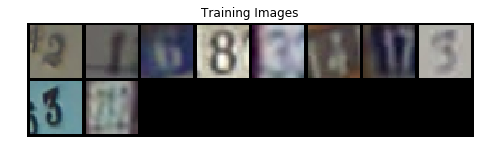

In [0]:

# Plot some training images
real_batch, _ = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:10], padding=2, normalize=True),(1,2,0)))



## Gan Model Classes

### Generator and Decoder model used in both VAE and GAN

In [0]:
class DecoderGenerator(nn.Module):
    def __init__(self):
        super(DecoderGenerator, self).__init__()
        linear_modules = [] 
        linear_modules.append(nn.Linear(noise_latent_dim, 4*4*4*n_feature_maps_g)) 
        linear_modules.append(nn.ReLU(True))
        self.fc_1 = nn.Sequential(*linear_modules)
        
        modules = []
        modules.append(nn.BatchNorm2d(n_feature_maps_g * 4))
        
        modules.append(nn.ConvTranspose2d(n_feature_maps_g*4, n_feature_maps_g * 2, 4, 2, 1, bias=False))
        modules.append(nn.BatchNorm2d( n_feature_maps_g * 2))
        modules.append(nn.ReLU(True))
        
        modules.append(nn.ConvTranspose2d(n_feature_maps_g*2, n_feature_maps_g , 4, 2, 1, bias=False))
        modules.append(nn.BatchNorm2d( n_feature_maps_g ))
        modules.append(nn.ReLU(True))

        modules.append(nn.ConvTranspose2d(n_feature_maps_g, 3 , 4, 2, 1, bias=False))
        
        self.main = nn.Sequential(*modules)


    def forward(self, input):
        input = self.fc_1(input)
        input = input.view(-1,4*n_feature_maps_g,4,4)
        return self.main(input)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.decoder = DecoderGenerator()
        self.tanh  = nn.Tanh()

    def forward(self, input):
        output = self.decoder(input)
        output = self.tanh(output)
        output = output.view(-1, 3,32,32)
        return output

### Discriminator Model

No batch norm in the discriminator since in the gradient penalty  we penalize the norm of the critic’s gradient with respect
to each input independently, and not the entire batch
as in https://arxiv.org/pdf/1704.00028.pdf

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        conv_modules = []
        conv_modules.append(
            nn.Sequential(
                nn.Conv2d(3, n_feature_maps_d , 5, 2, 2),#, bias=False),
                nn.LayerNorm([n_feature_maps_d, 16, 16])
            )
        )
        conv_modules.append(
            nn.Sequential(
                nn.Conv2d(n_feature_maps_d, n_feature_maps_d*2 , 5, 2, 2,),
                nn.LayerNorm([n_feature_maps_d*2, 8, 8])
            )
        )

        conv_modules.append(
            nn.Sequential(
                nn.Conv2d(n_feature_maps_d*2 , n_feature_maps_d * 4, 5, 2, 2),
                nn.LayerNorm([n_feature_maps_d*4, 4, 4])
            )
        )
        self.conv_modules = nn.ModuleList(conv_modules)
        self.fc = nn.Linear(4 * n_feature_maps_d * 4 * 4,1)

    def forward(self, input):
        # updated for this bug with autograd https://discuss.pytorch.org/t/freeing-buffer-strange-behavior/31955/8
        for conv in self.conv_modules:
            input = conv(input)
            input = F.leaky_relu(input,negative_slope=0.2)
        input = input.view(input.size(0), -1)  # reshape for linear layer
        return self.fc(input)

### WGAN-GP wrapper

In this setup we are updating the generator with same number of steps as the discriminator aka n critics = 1 but instead using different learning rate the discriminator's learning rate is 3 times the generator's learning rate (this value is tuned on this dataset) which is proven to work in https://arxiv.org/pdf/1706.08500.pdf

In [0]:
class WGanGP(object):
    def __init__(self,train_loader,val_loader,validate=True):
        super(WGanGP, self).__init__()
        self.img_list = []
        self.g_losses = []
        self.d_train_wd_losses = []
        self.val_wd_losses = []
        self.val_g_losses = []
        self.discriminator =  Discriminator().to(device)  

        self.generator = Generator().to(device) 

        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=lr_g, betas=(beta1, 0.9)) # Setup Adam optimizers for both G and D
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=lr_d, betas=(beta1, 0.9))
        
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.validate = validate
        self.total_iterations = len(train_loader) * n_epochs

    def calculate_discriminator_loss(self, real_images, fake_images ):

        disc_out_gen = self.discriminator(fake_images)
        disc_out_real = self.discriminator(real_images)

        alpha = torch.FloatTensor(batch_size,1,1,1).uniform_(0,1).to(device)
        alpha = alpha.expand(batch_size, real_images.size(1), real_images.size(2), real_images.size(3))

        interpolated = (1-alpha) * real_images.data + (alpha) * fake_images.data[:batch_size]
        interpolated = Variable(interpolated, requires_grad=True)

        # calculate probability of interpolated examples
        prob_interpolated = self.discriminator(interpolated)
        ones = torch.ones(prob_interpolated.size()).to(device)
        gradients = grad(outputs=prob_interpolated, inputs=interpolated,grad_outputs=ones,
                        create_graph=True,retain_graph=True)[0] # grad_outputs used as gradient output wrt each input we need it to be 1 to enforce Lipshitz property
        # calculate gradient penalty
        grad_penalty =  p_coeff * ((gradients.view(gradients.size(0), -1).norm(
            2, dim=1) - 1)**2).mean()  

        loss_wd = disc_out_gen.mean() -disc_out_real.mean()
        loss = disc_out_gen.mean() -disc_out_real.mean() + grad_penalty
        return loss, loss_wd

    def apply_zero_grad(self):
        self.discriminator.zero_grad() 
        self.generator.zero_grad()
    
    def enable_disc_disable_gen(self):
        gradients_status(self.discriminator, True) 
        gradients_status(self.generator, False)
    
    def enable_gen_disable_disc(self):
        gradients_status(self.discriminator, False) 
        gradients_status(self.generator, True)

    def disable_all(self):
        gradients_status(self.discriminator, False) 
        gradients_status(self.generator, False)
    
    def train(self):
        progress_bar =  tqdm(total=self.total_iterations)
        n_iterations = 0
        fixed_noise = sample_noise(batch_size)

        first_epoch = 0
        gan_model_name = 'gan_{}.tar'.format(model_prefix )

        if take_backup and download_file_drive(gan_model_name,gan_model_name):
            checkpoint = torch.load(gan_model_name)
            self.generator.load_state_dict(checkpoint['generator'])
            self.discriminator.load_state_dict(checkpoint['discriminator'])  
            self.optimizer_d.load_state_dict(checkpoint['optimizer_d'])
            self.optimizer_g.load_state_dict(checkpoint['optimizer_g'])
            self.g_losses = checkpoint['g_losses']
            self.d_train_wd_losses = checkpoint['discriminator_loss'] 
            self.val_wd_losses = checkpoint['val_wd_losses']
            self.val_g_losses = checkpoint['val_g_losses']

            first_epoch = checkpoint['epoch']
            n_iterations = first_epoch * len(self.train_loader)
            for i in range(n_iterations):
                progress_bar.update()
            
                
        uploaded_file_handle = None 
        for epoch in range(first_epoch, n_epochs): 
            for i, data in enumerate(self.train_loader, 0): 
                # disable gradients on generator and enable disc update
                self.apply_zero_grad()
                real_images = data[0].to(device) 
                noise = sample_noise(batch_size*generator_batch_size_factor).to(device)
                fake_images = self.generator(noise) 

                #############################
                # (2) Update G network every n_critic steps
                #############################
                if (i % n_critic )== 0 and i>0:

                    if self.validate: 
                        self.disable_all()
                        try:
                            val_images_tensor = next(val_iterator)[0].to(device)
                        except:
                            val_iterator = iter(self.val_loader)
                            val_images_tensor = next(val_iterator)[0].to(device)
                        val_disc_loss,val_disc_wd = self.calculate_discriminator_loss(val_images_tensor.data, fake_images.data)
                        self.val_wd_losses.append(val_disc_wd.item() * -1)
                        val_discriminator_output = self.discriminator(val_images_tensor)
                        val_generator_loss =  val_discriminator_output.mean()
                        self.val_g_losses.append(val_generator_loss.item())
                    
                    self.apply_zero_grad()
                    self.enable_gen_disable_disc()
                    noise = sample_noise(batch_size*generator_batch_size_factor).to(device)
                    fake_images = self.generator(noise) 
                    # using double batch size for the generator is better 
                    # to get a more meaningful signal from the discriminator 
                    # but was part of the experimentation 
                    discriminator_output_fake = self.discriminator(fake_images)
                    generator_loss = -discriminator_output_fake.mean()
                    generator_loss.backward()
                    self.optimizer_g.step()

                    self.g_losses.append(generator_loss.item()*-1)

                #############################
                # Calculating discriminator loss and updating discriminator
                #############################
                self.apply_zero_grad()
                self.enable_disc_disable_gen()
                disc_loss,disc_wd = self.calculate_discriminator_loss(real_images.data, fake_images.data)
                disc_loss.backward()
                self.optimizer_d.step()
                if i % n_critic == 0 and i>0:
                    self.d_train_wd_losses.append(disc_wd.item()*-1)

                if i % 50 == 0  and i>0 :
                    progress_bar.set_postfix({'Loss_D WD': str(self.d_train_wd_losses[-1]),'Loss_G':str(self.g_losses[-1]), 'Val_G':str(self.val_g_losses[-1]),'penalty':(disc_loss-disc_wd).item()})
                
                if (n_iterations % 500 == 0) or ((epoch == n_epochs-1) and (i == len(self.train_loader)-1)):
                
                    with torch.no_grad():
                        fake = self.generator(fixed_noise).detach().cpu()
                    images = vutils.make_grid(fake, padding=2, normalize=True)
                    self.img_list.append(images[:32])
                    vutils.save_image(images,'generated_images_{}.jpeg'.format(n_iterations),normalize=True)
                    

                n_iterations +=1
                progress_bar.update()
                # lr decay 
                if decay_lr:
                    decay = max(0.0,1.0-(n_iterations*1.0/self.total_iterations))
                    # update the learning rate
                    update_optimizer_lr(self.optimizer_d, lr_d, decay)
                    update_optimizer_lr(self.optimizer_g, lr_g, decay)

            if take_backup and epoch%backup_every==(backup_every-1):
                torch.save({
                    'generator': self.generator.state_dict(),
                    'discriminator': self.discriminator.state_dict(), 
                    'epoch': epoch,
                    'optimizer_d': self.optimizer_d.state_dict(), 
                    'optimizer_g': self.optimizer_g.state_dict(),
                    'discriminator_loss': self.d_train_wd_losses,
                    'val_wd_losses': self.val_wd_losses,
                    'g_losses': self.g_losses,
                    'val_g_losses': self.val_g_losses
                },gan_model_name)
                if not(uploaded_file_handle is None):
                    try:
                      uploaded_file_handle.Delete()
                    except:
                      pass
                uploaded_file_handle = upload_to_drive(gan_model_name)
                
        self.generator.eval()
    
    def generate_samples(self, n_samples, data_loader, output_folder='samples/data'):
        if not(os.path.isdir(output_folder)):
            os.makedirs(output_folder)
        n_images = 0
        with torch.no_grad():
            for i in range(0,n_samples,batch_size): 
                if n_images>=n_samples:
                    break
                z = sample_noise(batch_size * generator_batch_size_factor).to(device)
                images = self.generator(z).detach().cpu()
                for image_indx in range(images.size()[0]):
                    vutils.save_image(torch.squeeze(images[image_indx]),os.path.join(output_folder,'gan_{}.jpeg'.format(n_images)),normalize=True)
                    n_images +=1
                    if n_images>=n_samples:
                      break

### Model Init and Testing

In [0]:
generator_model = DecoderGenerator().to(device) 

# just testing the decoder size output in case of changing out image size
noise = sample_noise(batch_size)
print(generator_model(noise).size())

torch.Size([64, 3, 32, 32])


In [0]:

discriminator_model = Discriminator().to(device) 
# testing discriminator
print(torch.squeeze(discriminator_model(torch.randn((batch_size,3,32,32)).to(device))).size())


torch.Size([64])


In [0]:
summary(discriminator_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           4,864
         LayerNorm-2           [-1, 64, 16, 16]          32,768
            Conv2d-3            [-1, 128, 8, 8]         204,928
         LayerNorm-4            [-1, 128, 8, 8]          16,384
            Conv2d-5            [-1, 256, 4, 4]         819,456
         LayerNorm-6            [-1, 256, 4, 4]           8,192
            Linear-7                    [-1, 1]           4,097
Total params: 1,090,689
Trainable params: 1,090,689
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.44
Params size (MB): 4.16
Estimated Total Size (MB): 4.61
----------------------------------------------------------------


In [0]:
summary(generator_model, input_size=(1,noise_latent_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 4096]         413,696
              ReLU-2              [-1, 1, 4096]               0
       BatchNorm2d-3            [-1, 256, 4, 4]             512
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,072
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10            [-1, 3, 32, 32]           3,072
Total params: 1,073,024
Trainable params: 1,073,024
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.68
Params size (MB): 4.09
Estimat

## GAN Training

In [0]:
gan_model = WGanGP(train_loader,val_loader)
gan_model.train()

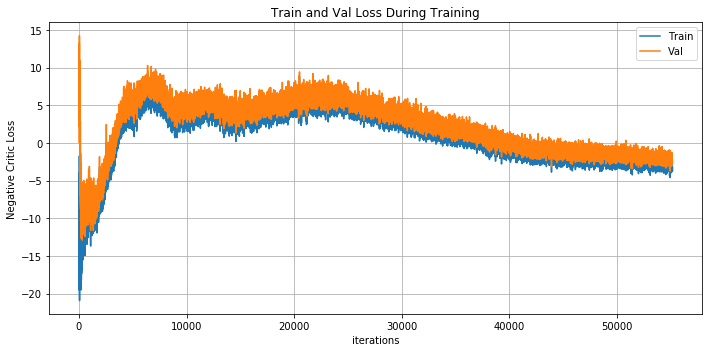

In [0]:
visualize_loss(gan_model.g_losses, gan_model.val_g_losses, 'Train', 'Val', 'Negative Critic Loss')

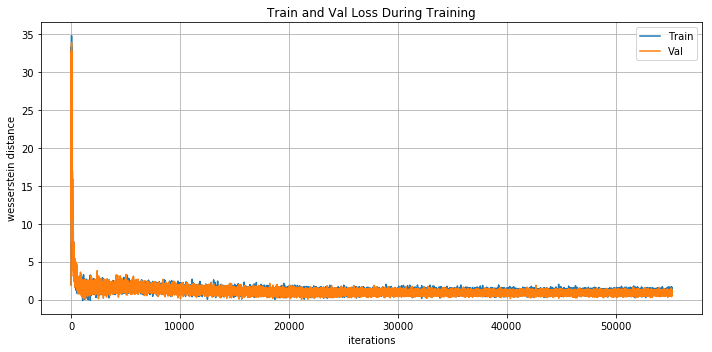

In [0]:
visualize_loss(gan_model.d_train_wd_losses, gan_model.val_wd_losses, 'Train', 'Val', 'wesserstein distance')

### Visualize Generated Images

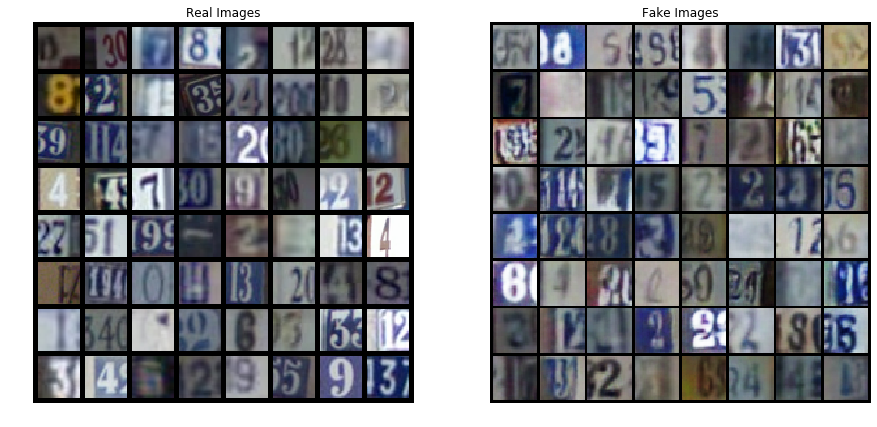

In [0]:
real_batch = next(iter(val_loader))[0]
images_generated = sample_image(gan_model.generator,batch_size).detach()
images_generated = vutils.make_grid(images_generated, padding=2, normalize=True)
show_real_fake_images(real_batch, images_generated.cpu())

### Disentangled Representation view

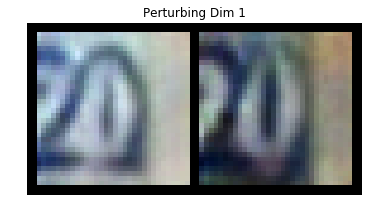

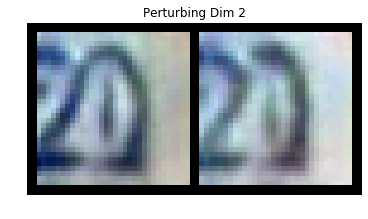

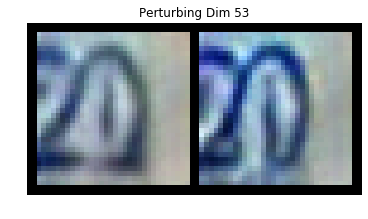

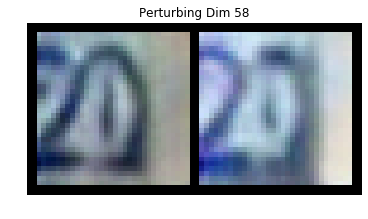

In [766]:
noise_1 = sample_noise(1)
disentangled_representation_view(gan_model.generator, noise_1, 4, [1,2,53,58],5)

### Latent Space Interpolation

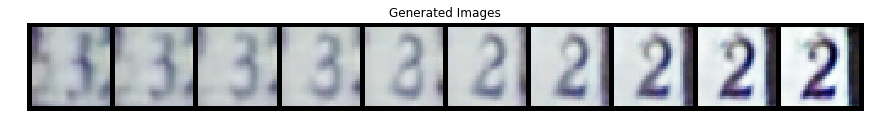

In [774]:
noise_1 = sample_noise(1)
noise_2 = sample_noise(1)
latent_space_interpolation(gan_model.generator, noise_1, noise_2, 10)


### Data Space Interpolation

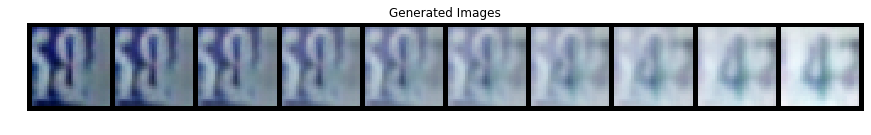

In [780]:
data_space_interpolation(gan_model.generator, 10)

### More Sample Plotting

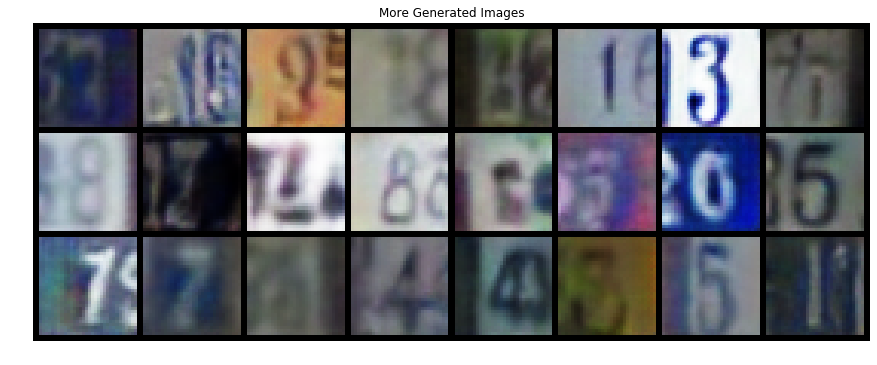

In [0]:
noise = sample_noise(batch_size)
with torch.no_grad():
        fake = gan_model.generator(noise).detach().cpu()
plt.figure(figsize=(15,15))
plt.axis('off')
plt.title("More Generated Images")
plt.imshow(vutils.make_grid(fake[:24], padding=2, normalize=True).permute(1,2,0))
plt.show()

In [0]:
! rm -r gan_generated

In [0]:
gan_model.generate_samples(1000, train_loader, 'gan_generated/data')

In [738]:
!python score_fid.py --model svhn_classifier.pt gan_generated

Test
Using downloaded and verified file: svhn/test_32x32.mat
FID score: 55818.94744079624


In [739]:
!python score_fid.py   gan_generated --use_inception True

Test
Loading inception
Using downloaded and verified file: svhn/test_32x32.mat
FID score: 43.5393170287885


## VAE Model Classes
The decoder is the same as the one used in the generator

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,n_feature_maps_d, kernel_size = 2, stride=2) , # n_feature_maps_d *16 * 16
            nn.BatchNorm2d(n_feature_maps_g),
            nn.ReLU(True),

            nn.Conv2d(n_feature_maps_d, n_feature_maps_d * 2, kernel_size = 2, stride =2),# n_feature_maps_d * 2 *8 * 8
            nn.BatchNorm2d(n_feature_maps_d * 2),
            nn.ReLU(True),

            nn.Conv2d(n_feature_maps_d*2, n_feature_maps_d * 4, kernel_size = 2, stride =2),# n_feature_maps_d * 4 *4 * 4
            nn.BatchNorm2d(n_feature_maps_d * 4),
            nn.ReLU(True)

        )
        
        hidden_dim  = n_feature_maps_d * 4 *4 * 4
        self.mean_linear = nn.Linear(hidden_dim, noise_latent_dim)
        self.log_var_linear = nn.Linear(hidden_dim, noise_latent_dim)
        
        self.decoder = DecoderGenerator()
        self.sigmoid = nn.Sigmoid()
        
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        z = mu + std * sample_noise(1)
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.mean_linear(h), self.log_var_linear(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar
      
    def decode(self,z):
        return self.sigmoid(self.decoder(z))

    def forward(self, x, inference=True):
        z, mu, logvar = self.encode(x)
        images = self.decode(z)
        
        if inference:
          return images
        return images, mu, logvar


In [0]:
class VAETrain(object):
    def __init__(self,train_loader,val_loader, validate=True):
        super(VAETrain, self).__init__()
        self.lr = 4e-3
        self.img_list = []
        self.reconstruction_error = []
        self.val_reconstruction_error = []
        self.val_kl_divergences = []
        self.kl_divergences = [] # kl divergence between the posterior q from the encoder and prior p expected by the decoder
        self.model =  VAE().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr) # requires higher learning rate than the one used by the GAN 
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.validate = True
        self.total_iterations = len(train_loader) * n_epochs

    def calculate_loss(self,generated_img , original_img , mu , logvar):
        batch_size = generated_img.size(0)
        reconstruction_error = F.mse_loss(generated_img.view(batch_size,-1),original_img.view(batch_size,-1),reduction='sum')
        
        # predicting logvar from the model to avoid log errors
        # # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        kldivergence = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  
        loss = reconstruction_error + kldivergence 
        return loss, reconstruction_error, kldivergence

    def train(self):
        progress_bar =  tqdm(total=self.total_iterations )
        n_iterations = 0
        first_epoch = 0
        
        vae_model_name = 'vae_{}.tar'.format(model_prefix )

        if take_backup and download_file_drive(vae_model_name,vae_model_name):
            checkpoint = torch.load(vae_model_name)
            self.model.load_state_dict(checkpoint['model'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.reconstruction_error = checkpoint['reconstruction_error']
            self.val_reconstruction_error = checkpoint['val_reconstruction_error']
            self.kl_divergences = checkpoint['kl_divergences']
            self.val_kl_divergences = checkpoint['val_kl_divergences']
            first_epoch = checkpoint['epoch']
            n_iterations = first_epoch * len(self.train_loader)
            for i in range(n_iterations):
                progress_bar.update() 
            return 
        
        # fixed images used to validate visually the output
        fixed_images = next(iter(self.val_loader))[0].to(device)
        fixed_noise = sample_noise(batch_size)
        uploaded_file_handle = None 
        val_iterator = iter(self.val_loader)
        for epoch in range(first_epoch, n_epochs): 
            for i, data in enumerate(self.train_loader, 0):  
                self.model.zero_grad()
                real_images_tensor = data[0].to(device)
                generated_images, mu, logvar = self.model(real_images_tensor,inference=False)

                loss, reconstruction_error, kld = self.calculate_loss(generated_images, real_images_tensor, mu, logvar)
                loss.backward()
                self.optimizer.step()
                
                self.kl_divergences.append(kld.item()/real_images_tensor.size(0))
                self.reconstruction_error.append(reconstruction_error.item()/real_images_tensor.size(0))


                if (n_iterations % 1000 == 0) or ((epoch == n_epochs-1) and (i == len(self.train_loader)-1)):
                    with torch.no_grad():
                        reconstructed_imgs = self.model(fixed_images).detach().cpu()
                    images = vutils.make_grid(reconstructed_imgs, padding=2, normalize=True)
                    self.img_list.append(images)
                    vutils.save_image(images,'vae_generated_images_{}.jpeg'.format(n_iterations),normalize=True)
                    with torch.no_grad():
                        reconstructed_imgs = self.model.decode(fixed_noise).detach().cpu()
                    images = vutils.make_grid(reconstructed_imgs, padding=2, normalize=True)
                    self.img_list.append(images)
                    vutils.save_image(images,'vae_generated_sampled_{}.jpeg'.format(n_iterations),normalize=True)
                    
                    
                if self.validate:
                    try:
                      val_images = next(val_iterator)[0].to(device)
                    except:
                      val_iterator = iter(self.val_loader)
                      val_images = next(val_iterator)[0].to(device)
                    with torch.no_grad():
                        generated_images, mu, logvar = self.model(val_images,inference=False)
                        _, reconstruction_error, kld = self.calculate_loss(generated_images, val_images, mu, logvar)
                        self.val_reconstruction_error.append(reconstruction_error.item()/val_images.size(0)) 
                        self.val_kl_divergences.append(kld.item()/val_images.size(0)) 
                        
                if i % 50 == 0  :
                    progress_bar.set_postfix({'Reconstruction Error': str(self.reconstruction_error[-1]),'KL Divergence':str(self.kl_divergences[-1]),'Val Error': self.val_reconstruction_error[-1]})
                
                n_iterations +=1
                progress_bar.update()
                if decay_lr:
                    decay = max(0, 1.0-(n_iterations*1.0/self.total_iterations))
                    update_optimizer_lr(self.optimizer, self.lr, decay)
            
            if take_backup and epoch%backup_every==0:
                torch.save({
                    'model': self.model.state_dict(),
                    'epoch': epoch,
                    'optimizer': self.optimizer.state_dict(),
                    'kl_divergences': self.kl_divergences,
                    'reconstruction_error': self.reconstruction_error,
                    'val_reconstruction_error': self.val_reconstruction_error,
                    'val_kl_divergences': self.val_kl_divergences
                },vae_model_name)
                if not(uploaded_file_handle is None):
                    try:
                      uploaded_file_handle.Delete()
                    except:
                      pass
                uploaded_file_handle = upload_to_drive(vae_model_name)
    
    def generate_samples(self, n_samples, data_loader, output_folder='samples/data'):
        if not(os.path.isdir(output_folder)):
            os.makedirs(output_folder)
        n_images = 0
        with torch.no_grad():
            for i in range(0,n_samples,batch_size): 
                if n_images>=n_samples:
                    break
                z = sample_noise(batch_size).to(device)
                images = self.model.decode(z).detach().cpu()
                for image_indx in range(images.size()[0]):
                    vutils.save_image(torch.squeeze(images[image_indx]),os.path.join(output_folder,'vae_generated_images_{}.jpeg'.format(n_images)),normalize=True)
                    n_images +=1
                    if n_images>=n_samples:
                      break

### Model Init and Testing

In [0]:

vae_model = VAE().to(device)

test_rand_image = torch.randn((batch_size,3,32,32)).to(device)
print(vae_model(test_rand_image).size())


torch.Size([64, 3, 32, 32])


In [0]:
summary(vae_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]             832
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
            Conv2d-4            [-1, 128, 8, 8]          32,896
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 4, 4]         131,328
       BatchNorm2d-8            [-1, 256, 4, 4]             512
              ReLU-9            [-1, 256, 4, 4]               0
           Linear-10                  [-1, 100]         409,700
           Linear-11                  [-1, 100]         409,700
           Linear-12                 [-1, 4096]         413,696
             ReLU-13                 [-1, 4096]               0
      BatchNorm2d-14            [-1, 25

## VAE Training

In [0]:
# now a sigmoid activation as we need positive activations
transformations = transforms.Compose([
                               transforms.Resize(32),
                               transforms.CenterCrop(32),
                               transforms.ToTensor(), # move from pil range [0,255] to [0,1] range and to tensor format
                              ])
train_loader, val_loader, test_loader = load_data(transformations)

VAE learnt the distribution of the data by fitting it into a multi-dimension normal distribution. This results at having the generated samples from VAE models to be blurry because of the independence assumption of the samples given latent variables. Ref: Page 1 in http://openreview.net/pdf?id=B1ElR4cgg

Download 100%.


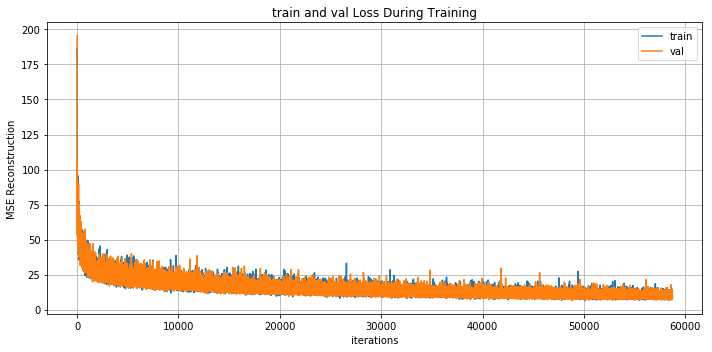

In [0]:
vae_model = VAETrain(train_loader, val_loader)
vae_model.train()
visualize_loss(vae_model.reconstruction_error, vae_model.val_reconstruction_error,'train','val', 'MSE Reconstruction')

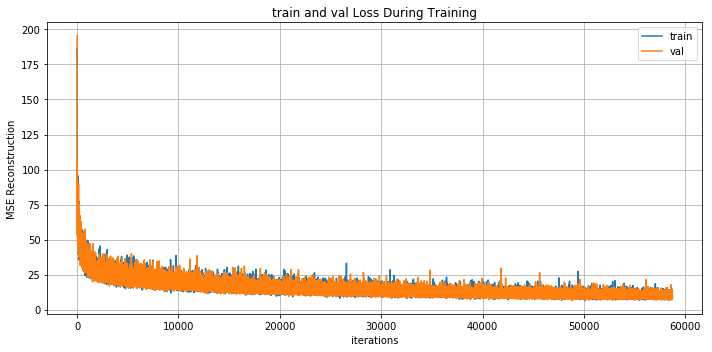

In [0]:
visualize_loss(vae_model.reconstruction_error, vae_model.val_reconstruction_error,'train','val', 'MSE Reconstruction')

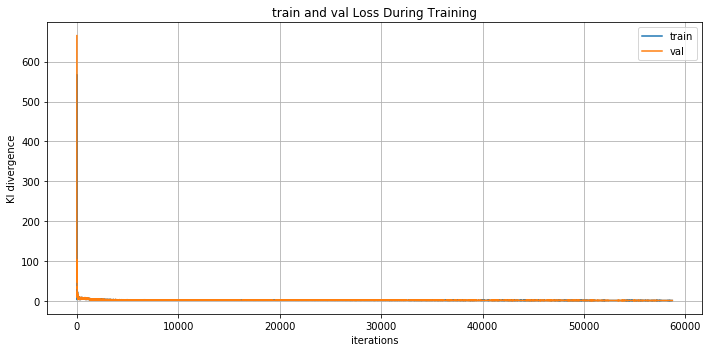

In [0]:
visualize_loss(vae_model.kl_divergences, vae_model.val_kl_divergences,'train','val', 'Kl divergence')

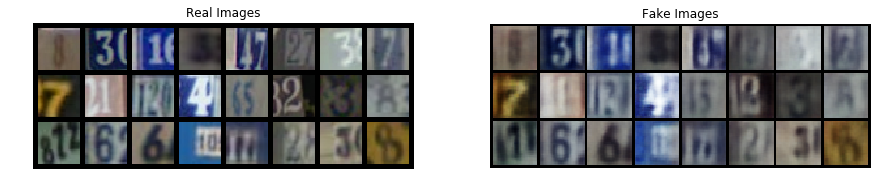

In [0]:

orig_images = next(iter(val_loader))[0].to(device)
with torch.no_grad():
  images_generated = vae_model.model(orig_images).detach().cpu()
  images_generated = vutils.make_grid(images_generated[:24], padding=2, normalize=True)
  show_real_fake_images(orig_images[:24], images_generated)

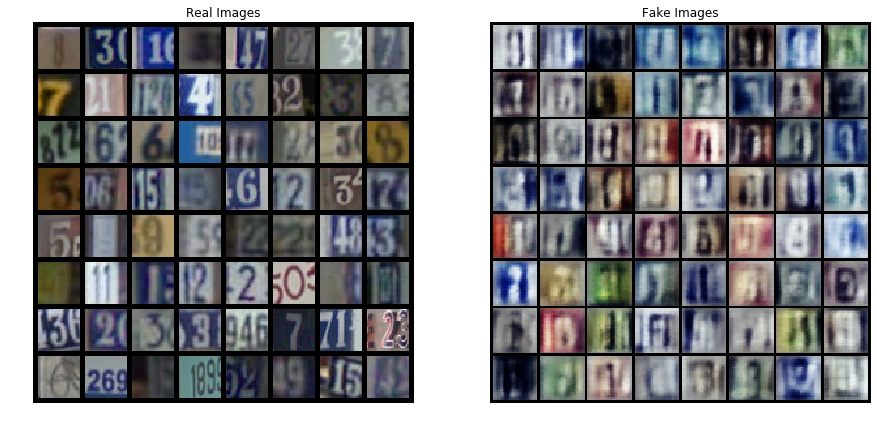

In [0]:
with torch.no_grad():
  images_generated = vae_model.model.decode(sample_noise(64)).detach() 
  images_generated = vutils.make_grid(images_generated, padding=2, normalize=True)
  show_real_fake_images(orig_images, images_generated.cpu())

### Disentangled Representation View

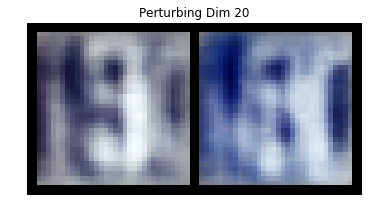

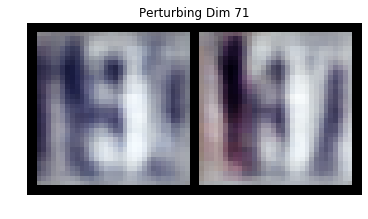

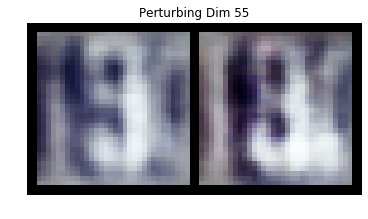

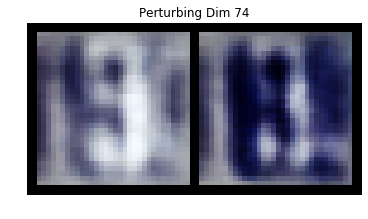

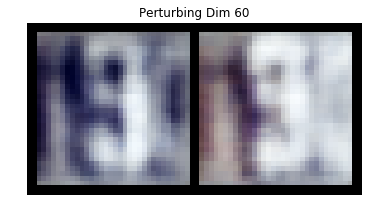

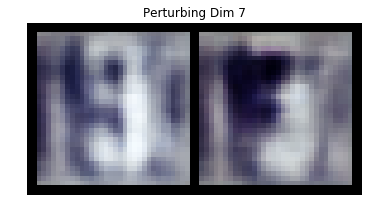

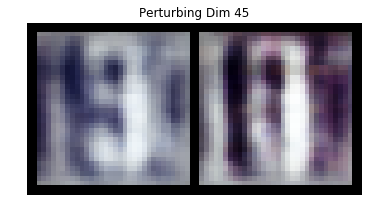

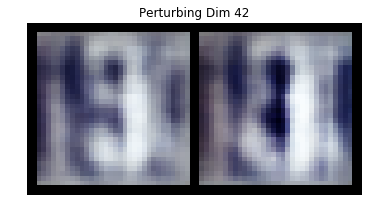

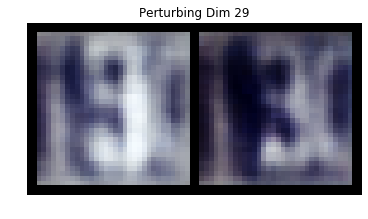

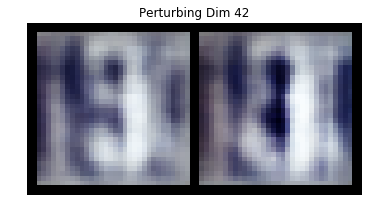

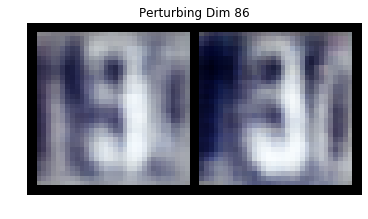

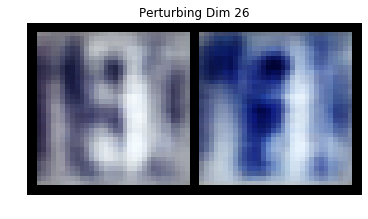

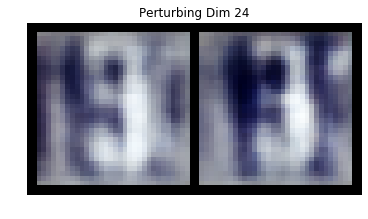

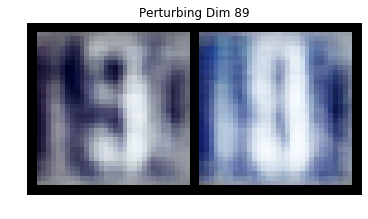

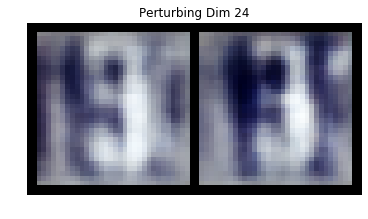

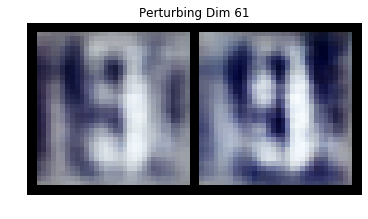

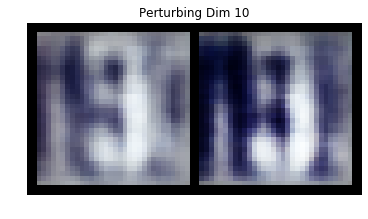

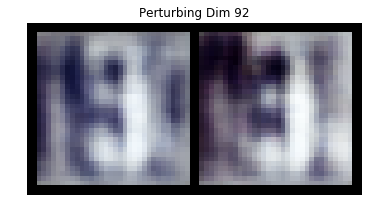

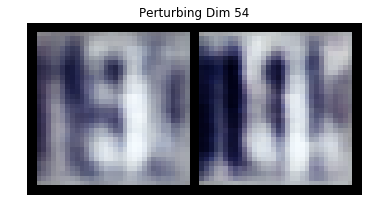

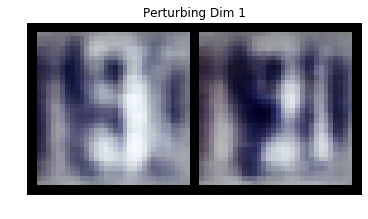

In [0]:
noise_1 = sample_noise(1)
disentangled_representation_view(vae_model.model.decode, noise_1, 20,[20,71,55],7)

### Latent Space Interpolation

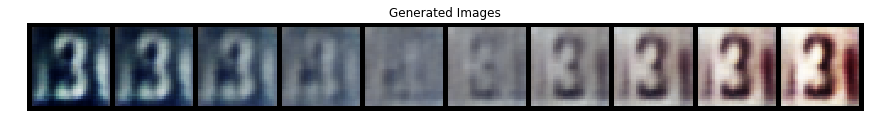

In [0]:

noise_1 = sample_noise(1)
noise_2 = sample_noise(1)
latent_space_interpolation(vae_model.model.decode, noise_1, noise_2, 10)

### Data Space Interpolation

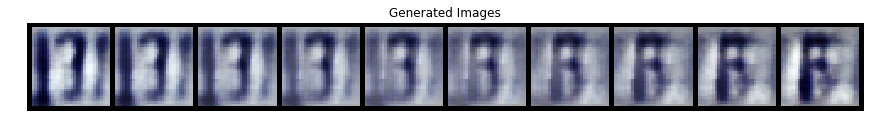

In [0]:

data_space_interpolation(vae_model.model.decode , 10)

In [0]:
!rm -r vae_generated

In [0]:
vae_model.model.eval()
vae_model.generate_samples(1000, train_loader, 'vae_generated/data')

In [740]:
!python score_fid.py --model svhn_classifier.pt vae_generated

Test
Using downloaded and verified file: svhn/test_32x32.mat
FID score: 44805.994336627016


In [741]:
!python score_fid.py   vae_generated --use_inception True

Test
Loading inception
Using downloaded and verified file: svhn/test_32x32.mat
FID score: 94.48140508523664
